# Find and Analyze Videos using GPT4-Vision with Video Enhancements

<img src="notebook-flow.png" alt="Alt text" width="800"/>

This notebook presents a detailed framework for analyzing videos, leveraging the latest in AI technology. It's a crucial resource for businesses across a range of industries, including marketing, media, education, manufacturing, healthcare, and retail. The key components of the notebook include:

1. __Video Upload and Storage__: It begins with uploading a local videos, along with their metadata, to Azure Storage, ensuring a centralized and accessible video repository.
2. __AI-Powered Indexing__: The creation of an Azure Vision AI index and the ingestion of videos into this system. This step facilitates advanced video search and retrieval capabilities.
3. __Targeted Video Retrieval__: The notebook demonstrates how to find relevant videos and specific scenes using text-based queries. 
4. __GPT4-Vision Analysis__: A major highlight is the use of GPT4-Vision with Video Enhancements. This tool is employed for summarizing videos and answering complex questions about the content.
5. __Systematic Content Analysis__: The notebook also details a systematic approach to content analysis for a set of videos using GPT4-Vision with Video Enhancements. 

Resources:

- https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/how-to/video-retrieval
- https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/reference-video-search
- https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/gpt-with-vision

Thank you to Divye Sheth and Anil Sener for their valuable contributions to this notebook.




In [15]:
import os
import time
import requests
import pandas as pd
import numpy as np
import base64
import io

from dotenv import load_dotenv
from azure.storage.blob import BlobClient
from azure.core.credentials import AzureSasCredential
import cv2
from IPython.display import Video, Markdown, HTML
from urllib.parse import quote
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', False)
%config InlineBackend.figure_format = 'retina'

## Setup

In [ ]:
load_dotenv()

VIDEO_DIR = "videos/samples"
VIDEO_INDEX = 'samples'

# For Azure AI Vision
AZURE_CV_KEY = os.getenv("AZURE_CV_KEY")
AZURE_CV_ENDPOINT = os.getenv("AZURE_CV_ENDPOINT")

# For Azure Storage Account
SAS_TOKEN = os.getenv("SAS_TOKEN")
STORAGE_ACCOUNT = os.getenv("STORAGE_ACCOUNT")
STORAGE_CONTAINER = os.getenv("STORAGE_CONTAINER")
STORAGE_PATH = 'samples/' 

# For Azure Open AI
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
AOAI_ENDPOINT = os.getenv("AOAI_ENDPOINT")
GPT_4V_DEPLOYMENT = os.getenv("GPT_4V_DEPLOYMENT")

GPT_4V_ENDPOINT = f"{AOAI_ENDPOINT}/openai/deployments/{GPT_4V_DEPLOYMENT}/extensions/chat/completions?api-version=2023-12-01-preview"

## Helper functions

In [3]:
def upload_file_to_blob(blob_name: str, source_dir=VIDEO_DIR, file_extension: str = ''):
    """
    Uploads a file to Azure Blob Storage.

    Args:
        blob_name (str): The name of the blob (file) to be uploaded.
        source_dir (str, optional): The directory of the source file. Defaults to VIDEO_DIR.
        file_extension (str, optional): The file extension (including the dot, e.g., '.mp4') to be appended to blob_name. Defaults to ''.

    Returns:
        str: The URL of the uploaded blob.

    """

    # Create a BlobClient object with data transfer options for upload
    account_url = "https://{}.blob.core.windows.net/".format(STORAGE_ACCOUNT)
    
    full_blob_name = os.path.join(STORAGE_PATH, blob_name + file_extension)
    encoded_blob_name = quote(full_blob_name)  # URL-encode the full_blob_name
    
    blob_client = BlobClient(
        account_url=account_url, 
        container_name=STORAGE_CONTAINER, 
        blob_name=full_blob_name,
        credential=AzureSasCredential(SAS_TOKEN),
        max_block_size=1024*1024*4,  # 4 MiB
        max_single_put_size=1024*1024*16  # 16 MiB
    )

    with open(file=os.path.join(source_dir, blob_name + file_extension), mode="rb") as data:
        blob_client.upload_blob(data=data, overwrite=True, max_concurrency=2)

    return account_url + STORAGE_CONTAINER + "/" + encoded_blob_name # + "?" + SAS_TOKEN

def local_videos_to_azure_blob(file_path, video_dir=VIDEO_DIR):

    video_path = os.path.join(video_dir, file_path)
    
    # extract metadata from video file  
    with VideoFileClip(video_path) as video:
        duration_mins = round(video.duration / 60,1)  # Duration in minutes
        fps = round(video.fps)  # Frames per second
        resolution = video.size  # Resolution (width, height)
    
    file_size_bytes = os.path.getsize(video_path)
    size_mb = round(file_size_bytes / (1024 * 1024),1)

    # upload video file to blob storage
    blob_url = upload_file_to_blob(file_path, video_dir)

    metadata = {
            'duration_mins': duration_mins,
            'fps': fps,
            'resolution': resolution,
            'document_url': blob_url,
            'size_mb' : size_mb
        }

    return metadata

def list_video_indexes(vision_api_endpoint, vision_api_key):
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key}

    response = requests.get(url, headers=headers)
    return response.json()

def delete_video_index(vision_api_endpoint, vision_api_key, index_name):
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key, "Content-Type": "application/json"}

    response = requests.delete(url, headers=headers)
    return response

def create_video_index(vision_api_endpoint, vision_api_key, index_name, metadata=False):
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key, "Content-Type": "application/json"}
    data = {
        "features": [
            {"name": "vision", "domain": "generic"},
            {"name": "speech"}
        ]
    }
    if metadata:
        data["metadataSchema"] = metadata
    response = requests.put(url, headers=headers, json=data)
    return response

def wait_for_ingestion_completion(vision_api_endpoint, vision_api_key, index_name, max_retries=30):
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}/ingestions?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key}
    retries = 0
    while retries < max_retries:
        time.sleep(10)
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            state_data = response.json()
            if state_data['value'][0]['state'] == 'Completed':
                print(state_data)
                print('Ingestion completed.')
                print(response)
                return True
            elif state_data['value'][0]['state'] == 'Failed':
                print(state_data)
                print('Ingestion failed.')
                return False
        retries += 1
    return False

def get_indexed_video_documents(vision_api_endpoint, vision_api_key, index_name):
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}/documents?api-version=2023-05-01-preview&$top=30"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key} # , "Content-Type": "application/json"}
    response = requests.get(url, headers=headers)
    return response

def find_scene(queryText="", featureFilters=["vision","speech"]):
    """
        Searches text over vision and/or speech features of an indexed video. It is also called frame locator or video retrieval api.
        It returns the relevant frames based on the text input and adname.

        Args:
            queryText: Free text input to search in "vision" and "speech" features
            featureFilters: Video features to search a given text, it is possible to select both or only one of "vision" and "speech"
        Returns:
            query_result : Response returned from video retrieval api, which is a list of most relevant frames with their confidence scores.
    """
    AZURE_CV_API_VERSION = os.getenv("AZURE_CV_API_VERSION")

    url = AZURE_CV_ENDPOINT +\
    "/computervision/retrieval/indexes/"+VIDEO_INDEX+":queryByText?api-version=2023-05-01-preview"

    headers = {
    'Content-type': 'application/json',
    'Ocp-Apim-Subscription-Key': AZURE_CV_KEY,
    }

    body = {
    "queryText": queryText,
    "dedup": True,
    "filters": {"featureFilters": featureFilters}
    }

    query_result=None
    try:

        r = requests.post(url, json=body, headers=headers)
        query_result=r.json()
    except Exception as error:
        print("Video search operation failed ")
        print(error)
    
    return query_result


def extract_frame(video_path, timestamp):
    """Extract a frame from a video at a given timestamp."""
    try:
        # Handle timestamps with fractional seconds
        h, m, s = timestamp.split(':')
        s, ms = (s.split('.') + ['0'])[:2]  # Split seconds and milliseconds, default ms to '0' if not present
        frame_time = (int(h) * 3600 + int(m) * 60 + int(s)) * 1000 + int(ms[:3])  # Convert to milliseconds

        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_MSEC, frame_time)

        success, frame = cap.read()
        if success:
            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert color to RGB for matplotlib
    except Exception as e:
        print(f"Error extracting frame: {e}")
    
    return None


def video_chat(video_url, document_id, user_prompt, sas_token=SAS_TOKEN, video_index=VIDEO_INDEX, gpt_4v_endpoint=GPT_4V_ENDPOINT, openai_api_key=OPENAI_API_KEY, azure_cv_endpoint=AZURE_CV_ENDPOINT, azure_cv_key=AZURE_CV_KEY):
    headers = {"Content-Type": "application/json", "api-key": openai_api_key}
    
    payload = {
        "model": "gpt-4-vision-preview", 
        "enhancements": {"video": {"enabled": True}},
        "dataSources": [{
            "type": "AzureComputerVisionVideoIndex",
            "parameters": {
                "computerVisionBaseUrl": f"{azure_cv_endpoint}/computervision",
                "computerVisionApiKey": azure_cv_key,
                "indexName": video_index,
                "videoUrls": [f"{video_url}?{sas_token}"]
            }
        }],
        "messages": [
            {"role": "system", "content": "You are a helpful assistant to analyze images and videos"},
            {"role": "user", "content": [{"type": "text", "text": user_prompt}, {"type": "acv_document_id", "acv_document_id": document_id}]}
        ],
        "max_tokens": 1000, 
        "temperature": 0,
        "seed": 1
    }

    try:
        response = requests.post(gpt_4v_endpoint, headers=headers, json=payload)
        response.raise_for_status()
        content = response.json()["choices"][0]['message']['content']
        return content
    except requests.RequestException as e:
        raise SystemExit(f"Failed to make the request. Error: {e}")

def display_tiles(matches_df, nrows=2, ncols=3, figsize=(16, 9)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=100)
    axes = axes.flatten()

    for i, (ax, (_, row)) in enumerate(zip(axes, matches_df.iterrows())):
        video_path = f"{VIDEO_DIR}/{row['documentId']}"
        timestamp = row['best']
        frame = extract_frame(video_path, timestamp)

        if frame is not None:
            ax.imshow(frame)
        else:
            ax.imshow(np.zeros((100, 100, 3), dtype=np.uint8))  # Display an empty black frame

        title = f"Top {i+1}, (score: {row['relevance']:.3f}) - Video id: {row['documentId']}"

        # Adjusting the timestamp format to remove sub-second information
        start = row['start'].split('.')[0] if 'start' in row else None
        end = row['end'].split('.')[0] if 'end' in row else None
        subtitle = f"{start} - {end}" if start and end else "Timestamp not available"
        
        ax.set_title(f"{title}\n{subtitle}", fontsize=10, pad=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    
def image_to_html(image, format='jpeg'):
    buffer = io.BytesIO()
    plt.imsave(buffer, image, format=format)
    data_uri = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return f'<img src="data:image/{format};base64,{data_uri}" width="200">'

## Index local videos with Azure Vision AI

In [4]:
video_files = [filename for filename in os.listdir(VIDEO_DIR) if filename.lower().endswith(".mp4")]

# Create DataFrame with id column from video files
video_df = pd.DataFrame({"id": video_files})

# Apply the local_videos_to_azure_blob function directly
metadata_df = video_df['id'].apply(local_videos_to_azure_blob)

# Convert the dictionary to a DataFrame and join with the original DataFrame
metadata_df = pd.DataFrame(metadata_df.tolist())
video_df = video_df.join(metadata_df)

video_df["filename"] = video_df["id"]

display(video_df)

id  duration_mins  fps    resolution  \
0  Copilots and Plugins.mp4                6.0            30   [1280, 720]    
1  Create Avatar Videos.mp4                1.8            24   [1920, 1080]   
2  Quantum Computing on Azure.mp4          14.9           30   [1280, 720]    
3  Retail scene.mp4                        11.7           30   [852, 480]     
4  Factory scene.mp4                       3.5            30   [852, 480]     
5  Warehouse scene.mp4                     10.9           30   [852, 480]     
6  Jugalbandi Chat Bot.mp4                 2.5            30   [1280, 720]    
7  Solve Humanitys Challenges with AI.mp4  3.3            30   [1280, 720]    

                                                                                         document_url  \
0  https://saaksc.blob.core.windows.net/videos/samples/Copilots%20and%20Plugins.mp4                     
1  https://saaksc.blob.core.windows.net/videos/samples/Create%20Avatar%20Videos.mp4                     
2  https://saaksc.blob.core.windows.net/videos/samples/Quantum%20Computing%20on%20Azure.mp4             
3  https://saaksc.blob.core.windows.net/videos/samples/Retail%20scene.mp4                               
4  https://saaksc.blob.core.windows.net/videos/samples/Factory%20scene.mp4                              
5  https://saaksc.blob.core.windows.net/videos/samples/Warehouse%20scene.mp4                            
6  https://saaksc.blob.core.windows.net/videos/samples/Jugalbandi%20Chat%20Bot.mp4                      
7  https://saaksc.blob.core.windows.net/videos/samples/Solve%20Humanitys%20Challenges%20with%20AI.mp4   

   size_mb                                filename  
0  11.7     Copilots and Plugins.mp4                
1  49.1     Create Avatar Videos.mp4                
2  42.9     Quantum Computing on Azure.mp4          
3  23.7     Retail scene.mp4                        
4  24.8     Factory scene.mp4                       
5  23.8     Warehouse scene.mp4                     
6  23.7     Jugalbandi Chat Bot.mp4                 
7  41.9     Solve Humanitys Challenges with AI.mp4

In [10]:
# list existing indexes
indexes = list_video_indexes(AZURE_CV_ENDPOINT, AZURE_CV_KEY)
index_names = [index['name'] for index in indexes['value']]
print(index_names)

['56mdrm2lcy0', 'microsoft', 'samples', 'sid185p38tx']


In [11]:
# delete existing index
response = delete_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)
print(response.status_code, response.text) # 204 expected

# define additional metadata fields 
metadata = {"language" : "en",
            "fields" : [
                {"name": "filename", "searchable": False, "filterable": True, "type": "string"},
                {"name": "duration_mins", "searchable": False, "filterable": True, "type": "string"},
                {"name": "size_mb", "searchable": False, "filterable": True, "type": "string"},
                {"name": "resolution", "searchable": False, "filterable": True, "type": "string"},
                {"name": "fps", "searchable": False, "filterable": True, "type": "string"},
            ]}

# create index
response = create_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX, metadata)
print(response.status_code, response.text) 

204 
201 {"name":"samples","metadataSchema":{"language":"en","fields":[{"name":"filename","searchable":false,"filterable":true,"type":"string"},{"name":"duration_mins","searchable":false,"filterable":true,"type":"string"},{"name":"size_mb","searchable":false,"filterable":true,"type":"string"},{"name":"resolution","searchable":false,"filterable":true,"type":"string"},{"name":"fps","searchable":false,"filterable":true,"type":"string"}]},"userData":{},"features":[{"name":"vision","modelVersion":"2022-04-11","domain":"generic"},{"name":"speech","modelVersion":"2023-06-30","domain":"generic"}],"eTag":"\"2656345731c0490a844db6be303b25de\"","createdDateTime":"2024-01-24T14:05:46.5664759Z","lastModifiedDateTime":"2024-01-24T14:05:46.5664759Z"}


In [12]:
INGESTION_NAME = f"{VIDEO_INDEX}-ingestion"
url = f"{AZURE_CV_ENDPOINT}/computervision/retrieval/indexes/{VIDEO_INDEX}/ingestions/{INGESTION_NAME}?api-version=2023-05-01-preview"
headers = {"Ocp-Apim-Subscription-Key": AZURE_CV_KEY, "Content-Type": "application/json"}

# Function to structure video data for indexing
def index_video(video):
    return {
        "mode": "add",
        "documentId": video["id"],
        "documentUrl": video['document_url'] + "?" + SAS_TOKEN,
        "metadata": {
            "filename": video["filename"],
            "duration_mins": str(video["duration_mins"]),
            "size_mb" : str(video["size_mb"]),
            "resolution": str(video["resolution"]),
            "fps": str(video["fps"]),
        }
    }

videos = [index_video(video) for _, video in video_df.iterrows()]
body = {"videos": videos, "includeSpeechTranscript": True, "moderation": False}

r = requests.put(url, json=body, headers=headers)
result = r.json()
print(result)

{'name': 'samples-ingestion', 'state': 'Running', 'batchName': 'bff99d22-25f3-44f3-8f07-de478f71c240', 'createdDateTime': '2024-01-24T14:05:49.7696185Z', 'lastModifiedDateTime': '2024-01-24T14:06:21.4258124Z'}


In [23]:
# Wait for ingestion to complete
if not wait_for_ingestion_completion(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX):
    print("Ingestion did not complete within the expected time.")

{'value': [{'name': 'samples-ingestion', 'state': 'Completed', 'batchName': 'bff99d22-25f3-44f3-8f07-de478f71c240', 'createdDateTime': '2024-01-24T14:05:49.7696185Z', 'lastModifiedDateTime': '2024-01-24T14:12:33.5346582Z'}]}
Ingestion completed.
<Response [200]>



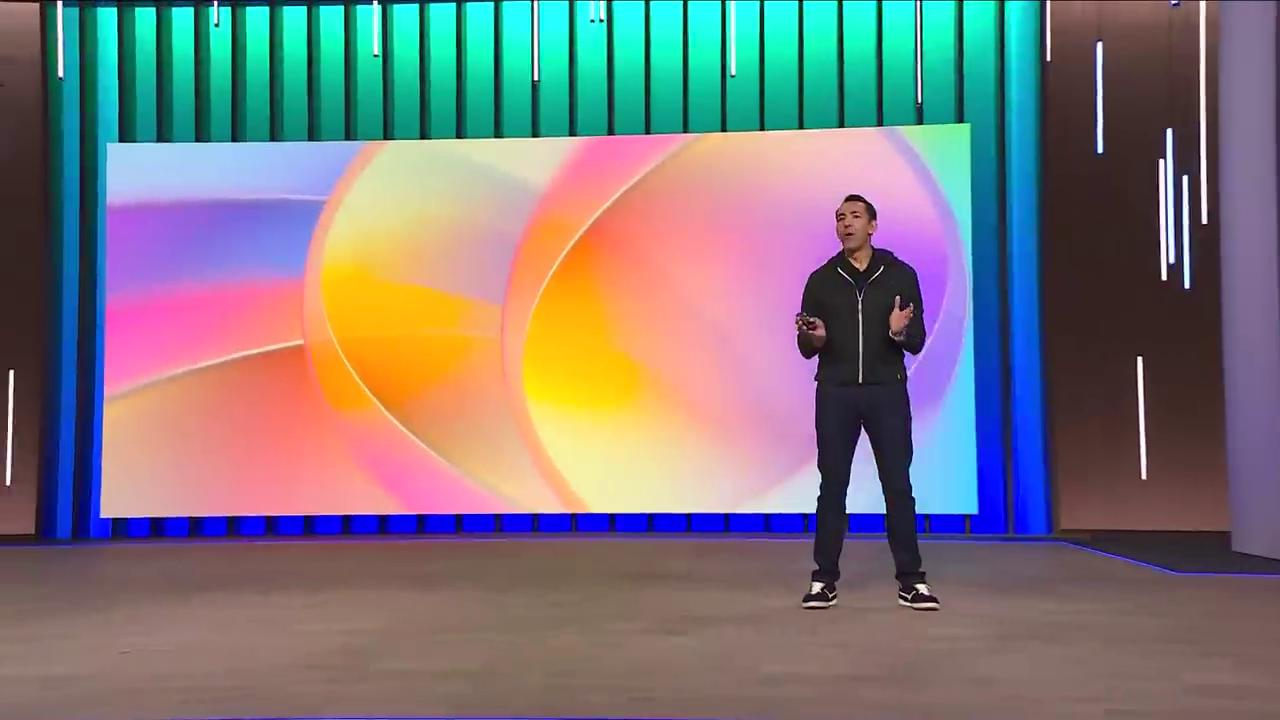
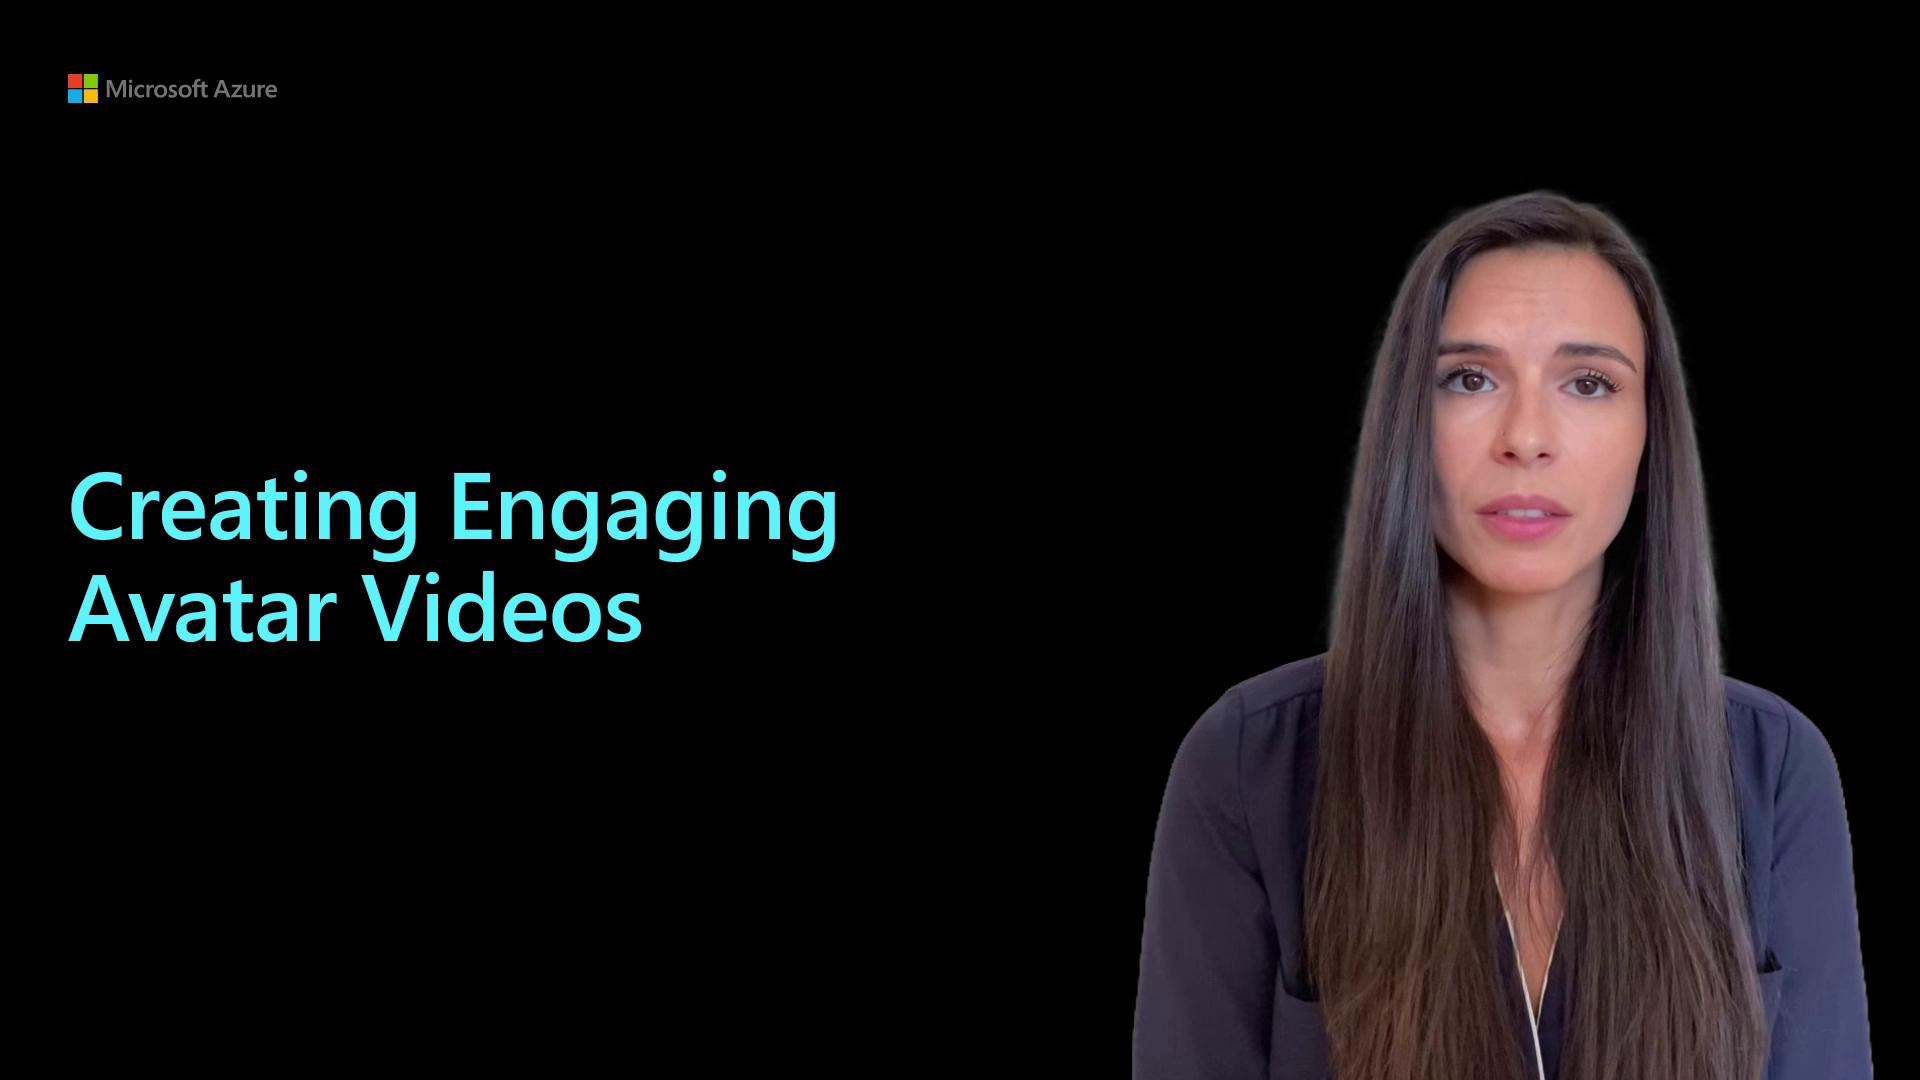
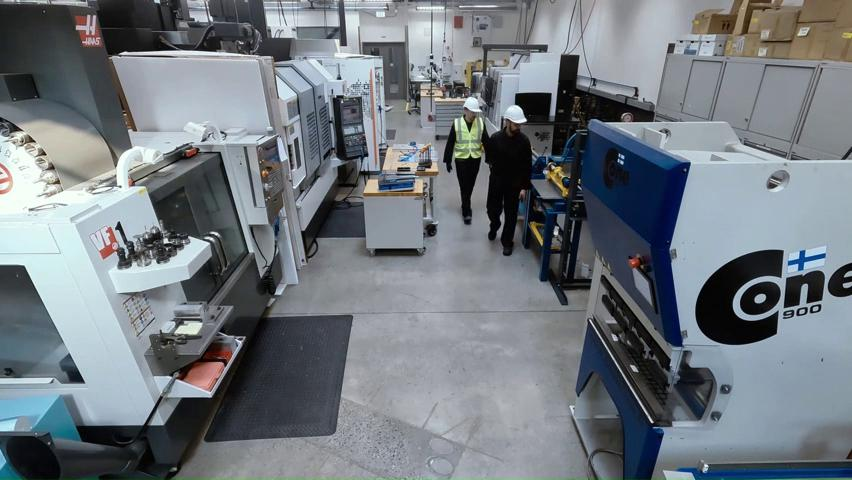
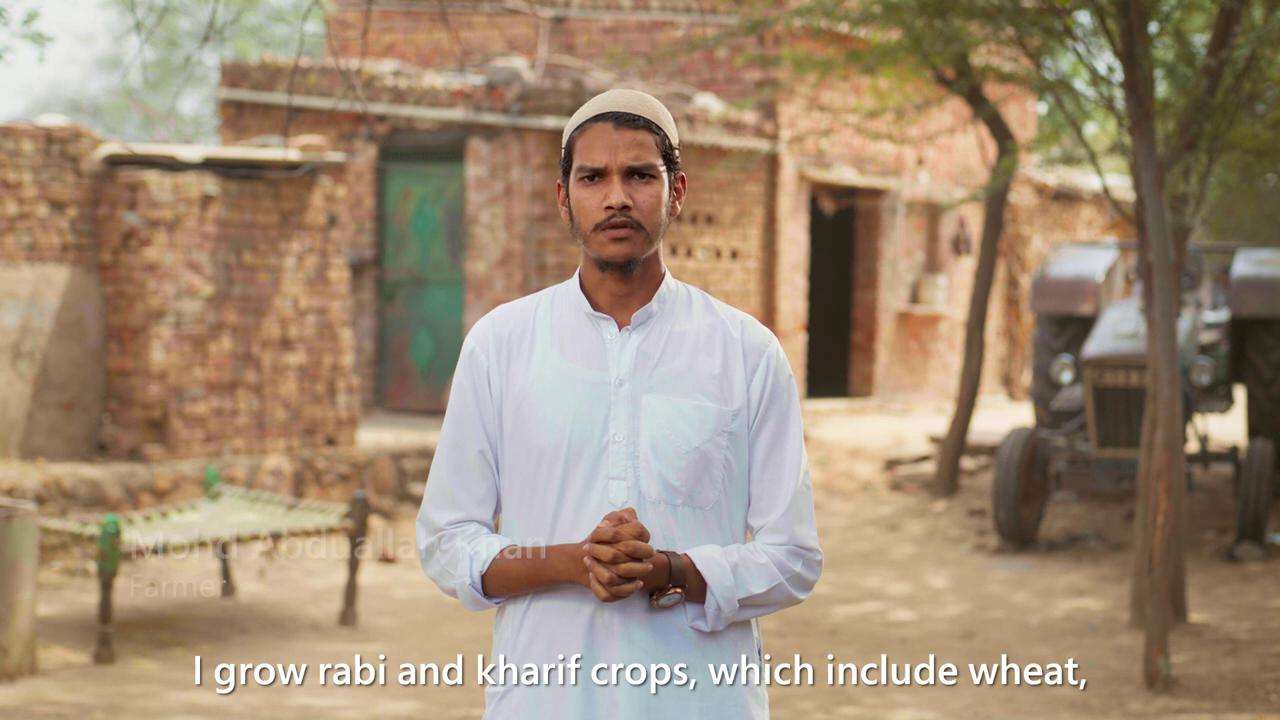
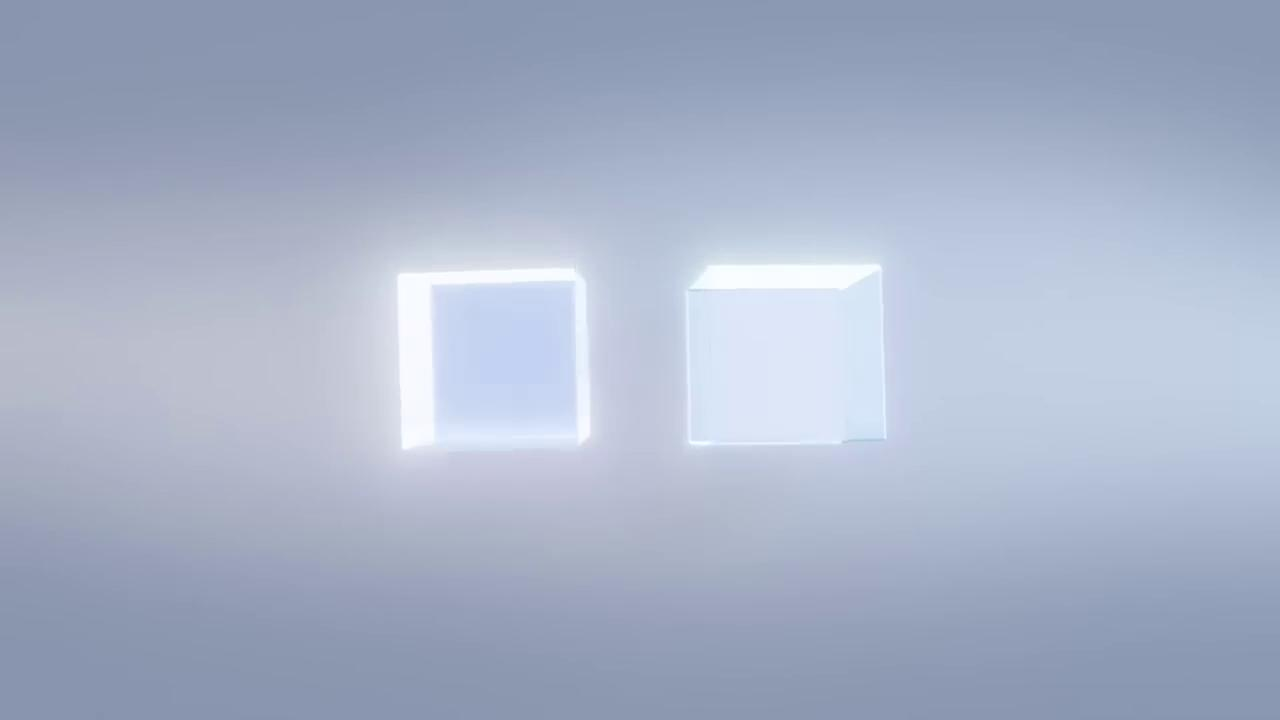
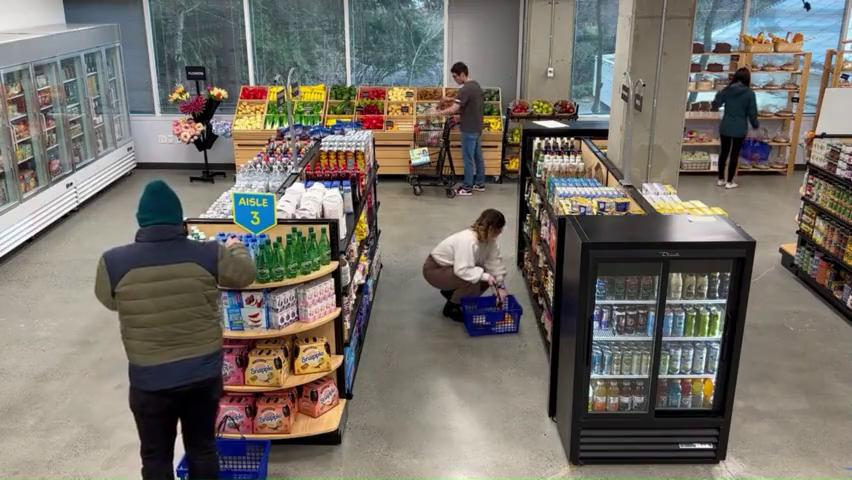
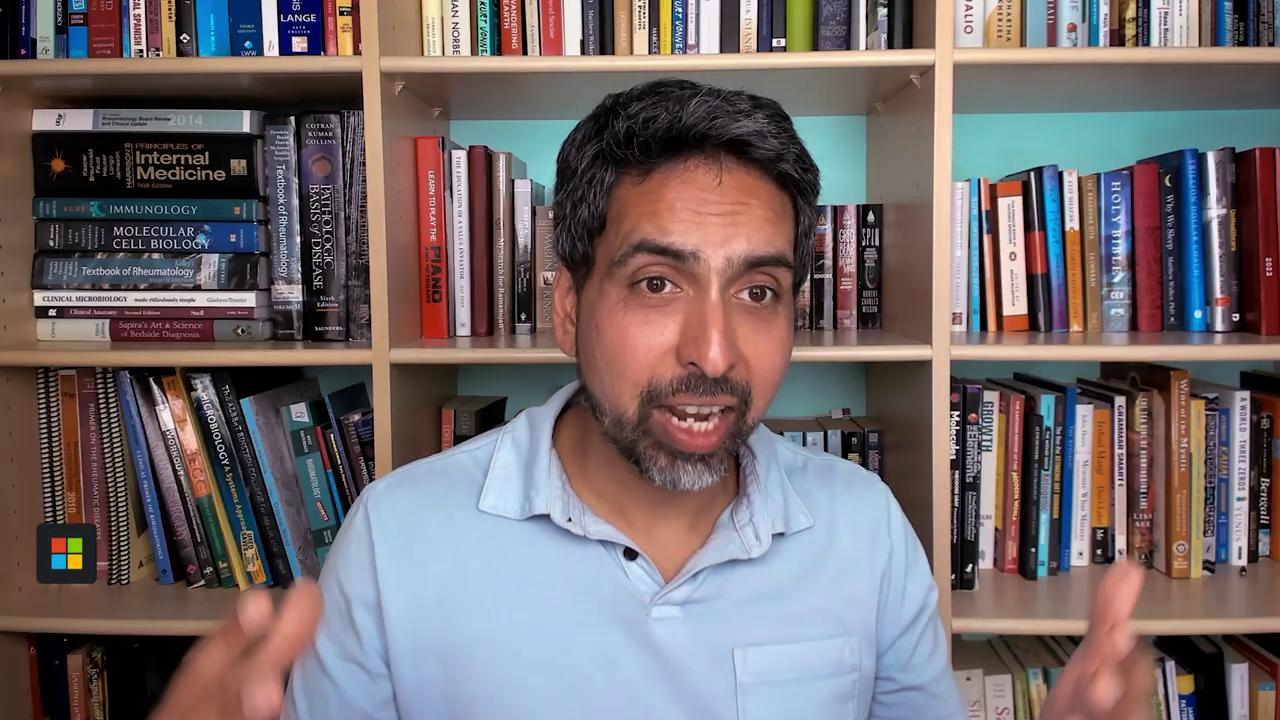
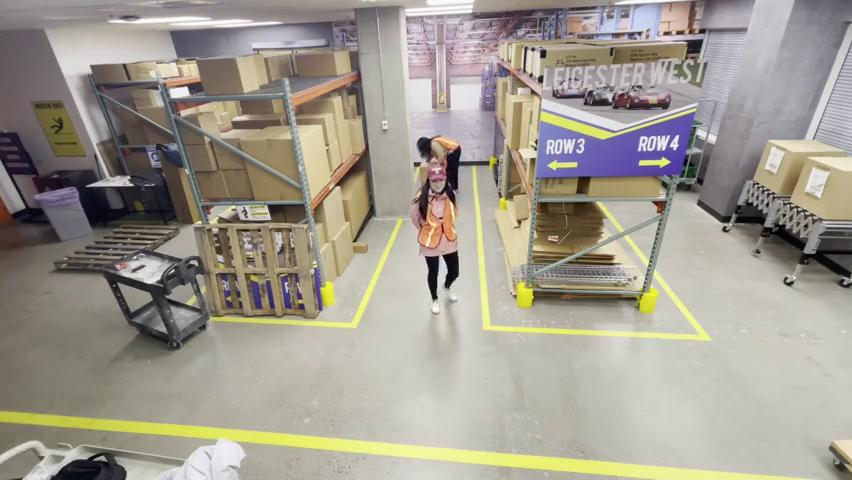

In [19]:
# show indexed videos
response = get_indexed_video_documents(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)

indexed_videos_df=pd.DataFrame.from_records(response.json()["value"])
metadata_fields=pd.json_normalize(indexed_videos_df["metadata"])
indexed_videos_df=pd.concat([indexed_videos_df,metadata_fields], axis=1)
del indexed_videos_df["metadata"]

# Generate thumbnails and add them to the DataFrame
thumbnails = []
for url in indexed_videos_df['documentUrl']:
    video_url = url + '?' + SAS_TOKEN
    thumbnail = extract_frame(video_url, '00:00:10')
    thumbnails.append(image_to_html(thumbnail) if thumbnail is not None else "")

indexed_videos_df['thumbnail'] = thumbnails

# Create HTML table
html_table = indexed_videos_df[['thumbnail', 'filename', 'duration_mins', 'size_mb', 'resolution', 'fps', 'createdDateTime', 'documentUrl']].copy()
html_table = html_table.to_html(escape=False)  # Set escape=False to render images

display(HTML(html_table))

## Find videos and scenes by text query
The more specific your search term is, the better tend to be the search results. Feel free to try these queries with our samples:
- "indian farmer with smartphone using chatbot"
- "person lying on the floor"
- "surface laptop"
- "agricultural drone"


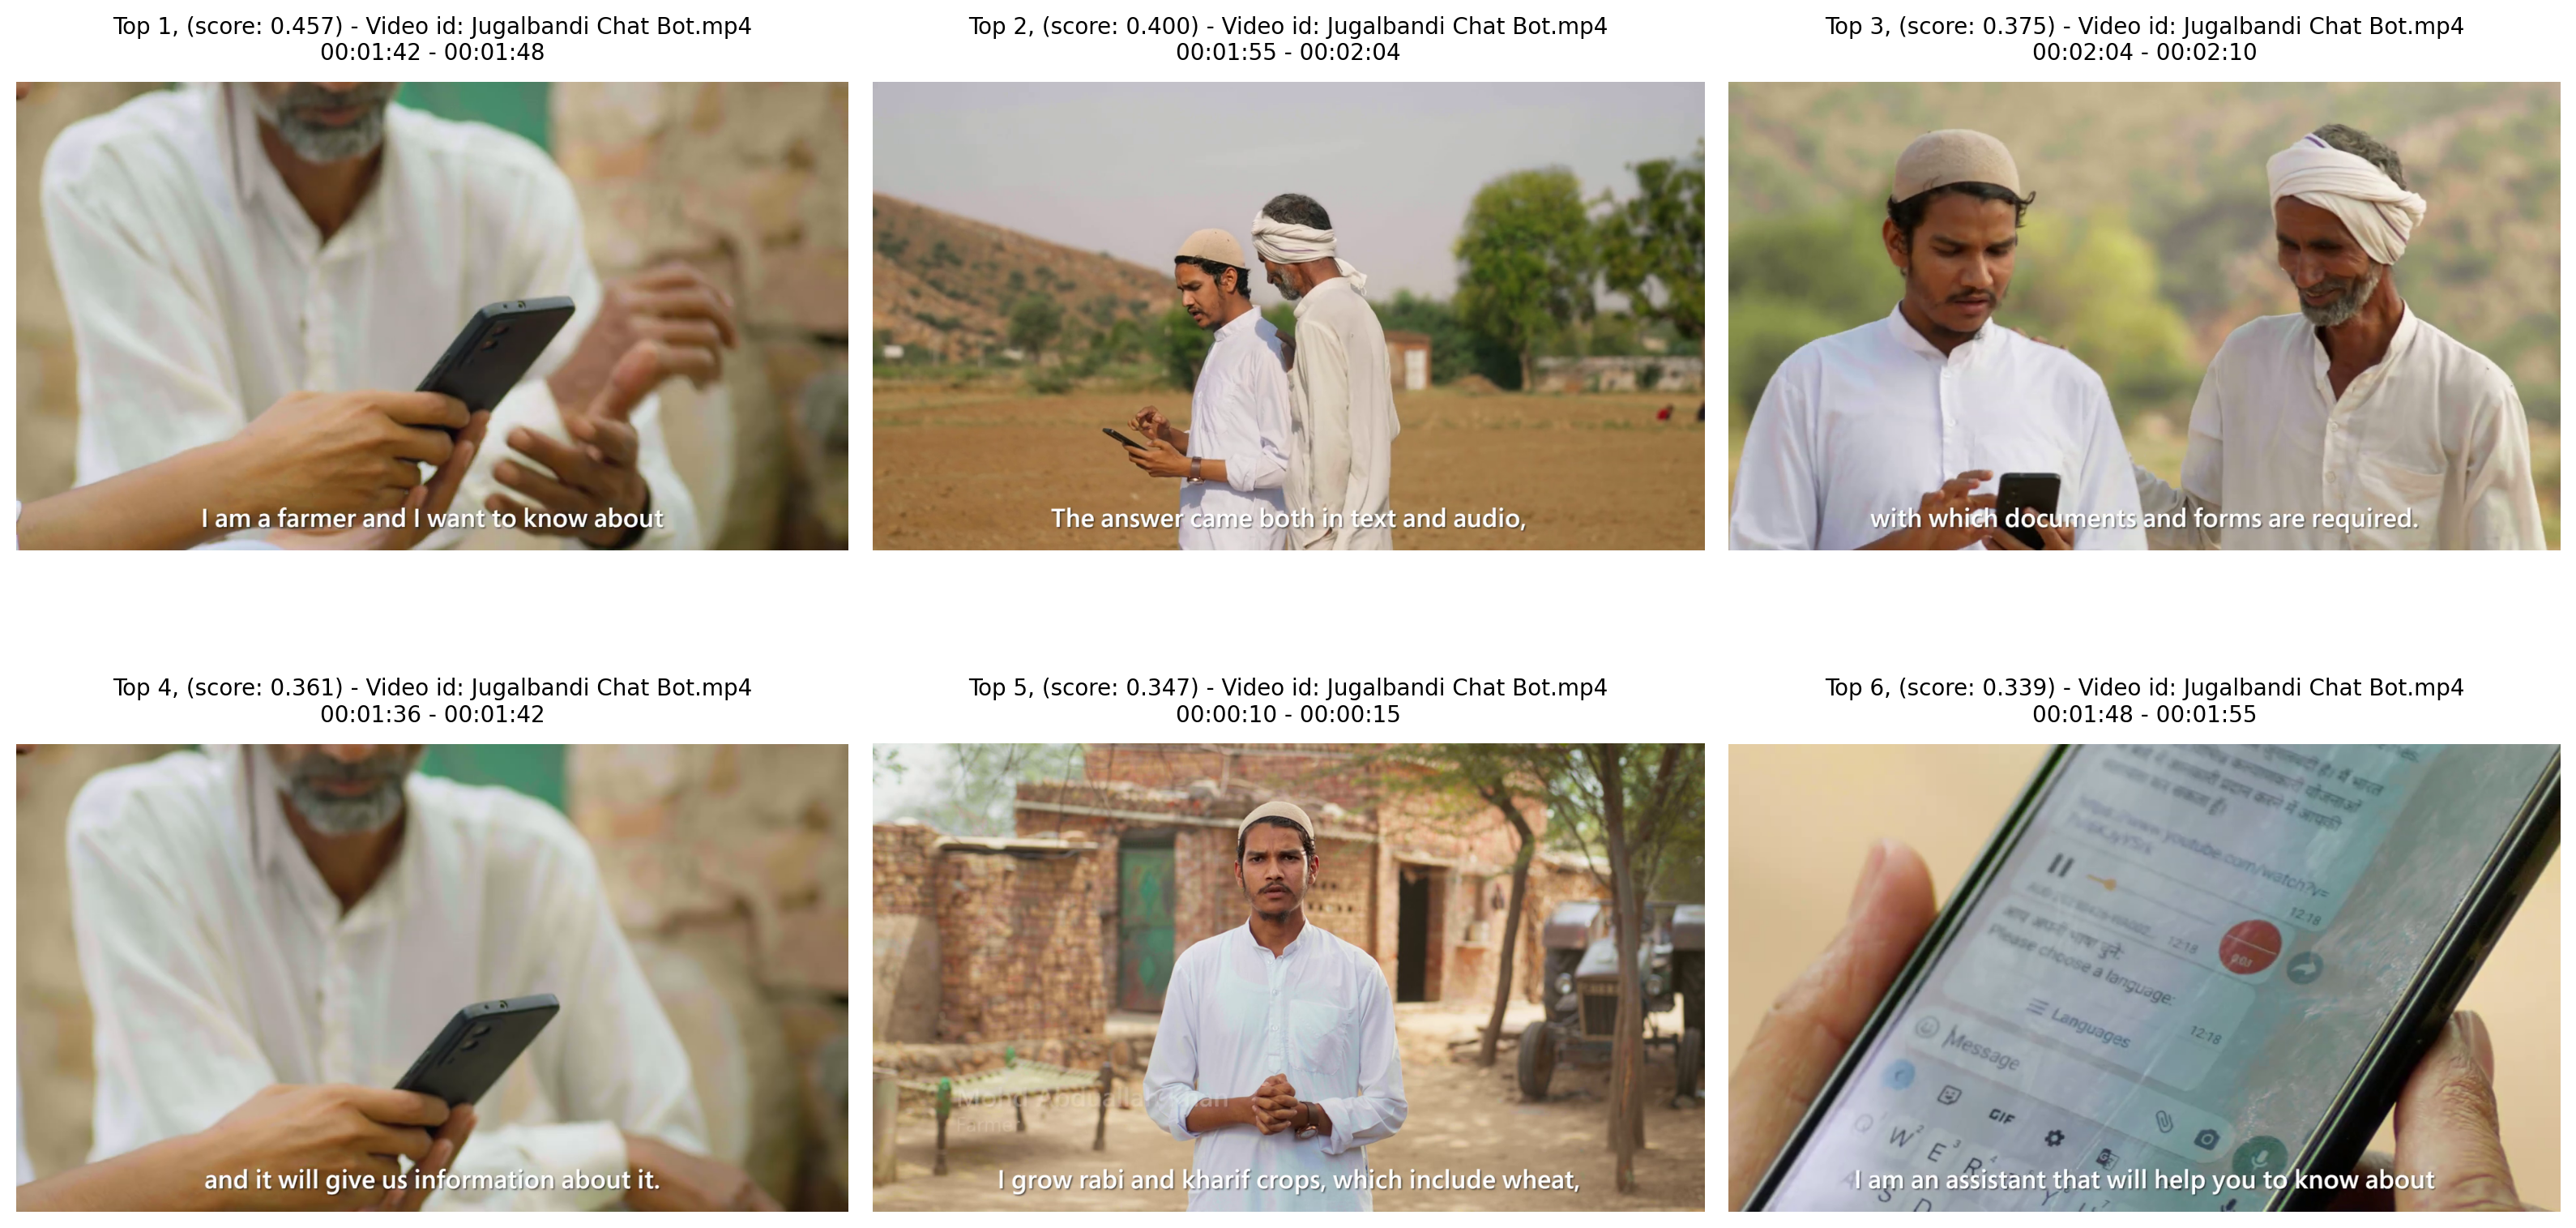

In [20]:
# search in video track only
query = "indian farmer with smartphone using chatbot"
search_results=find_scene(queryText=query, featureFilters=["vision"])['value']
top_matches_df=pd.DataFrame.from_records(search_results).head(6)

display_tiles(top_matches_df)

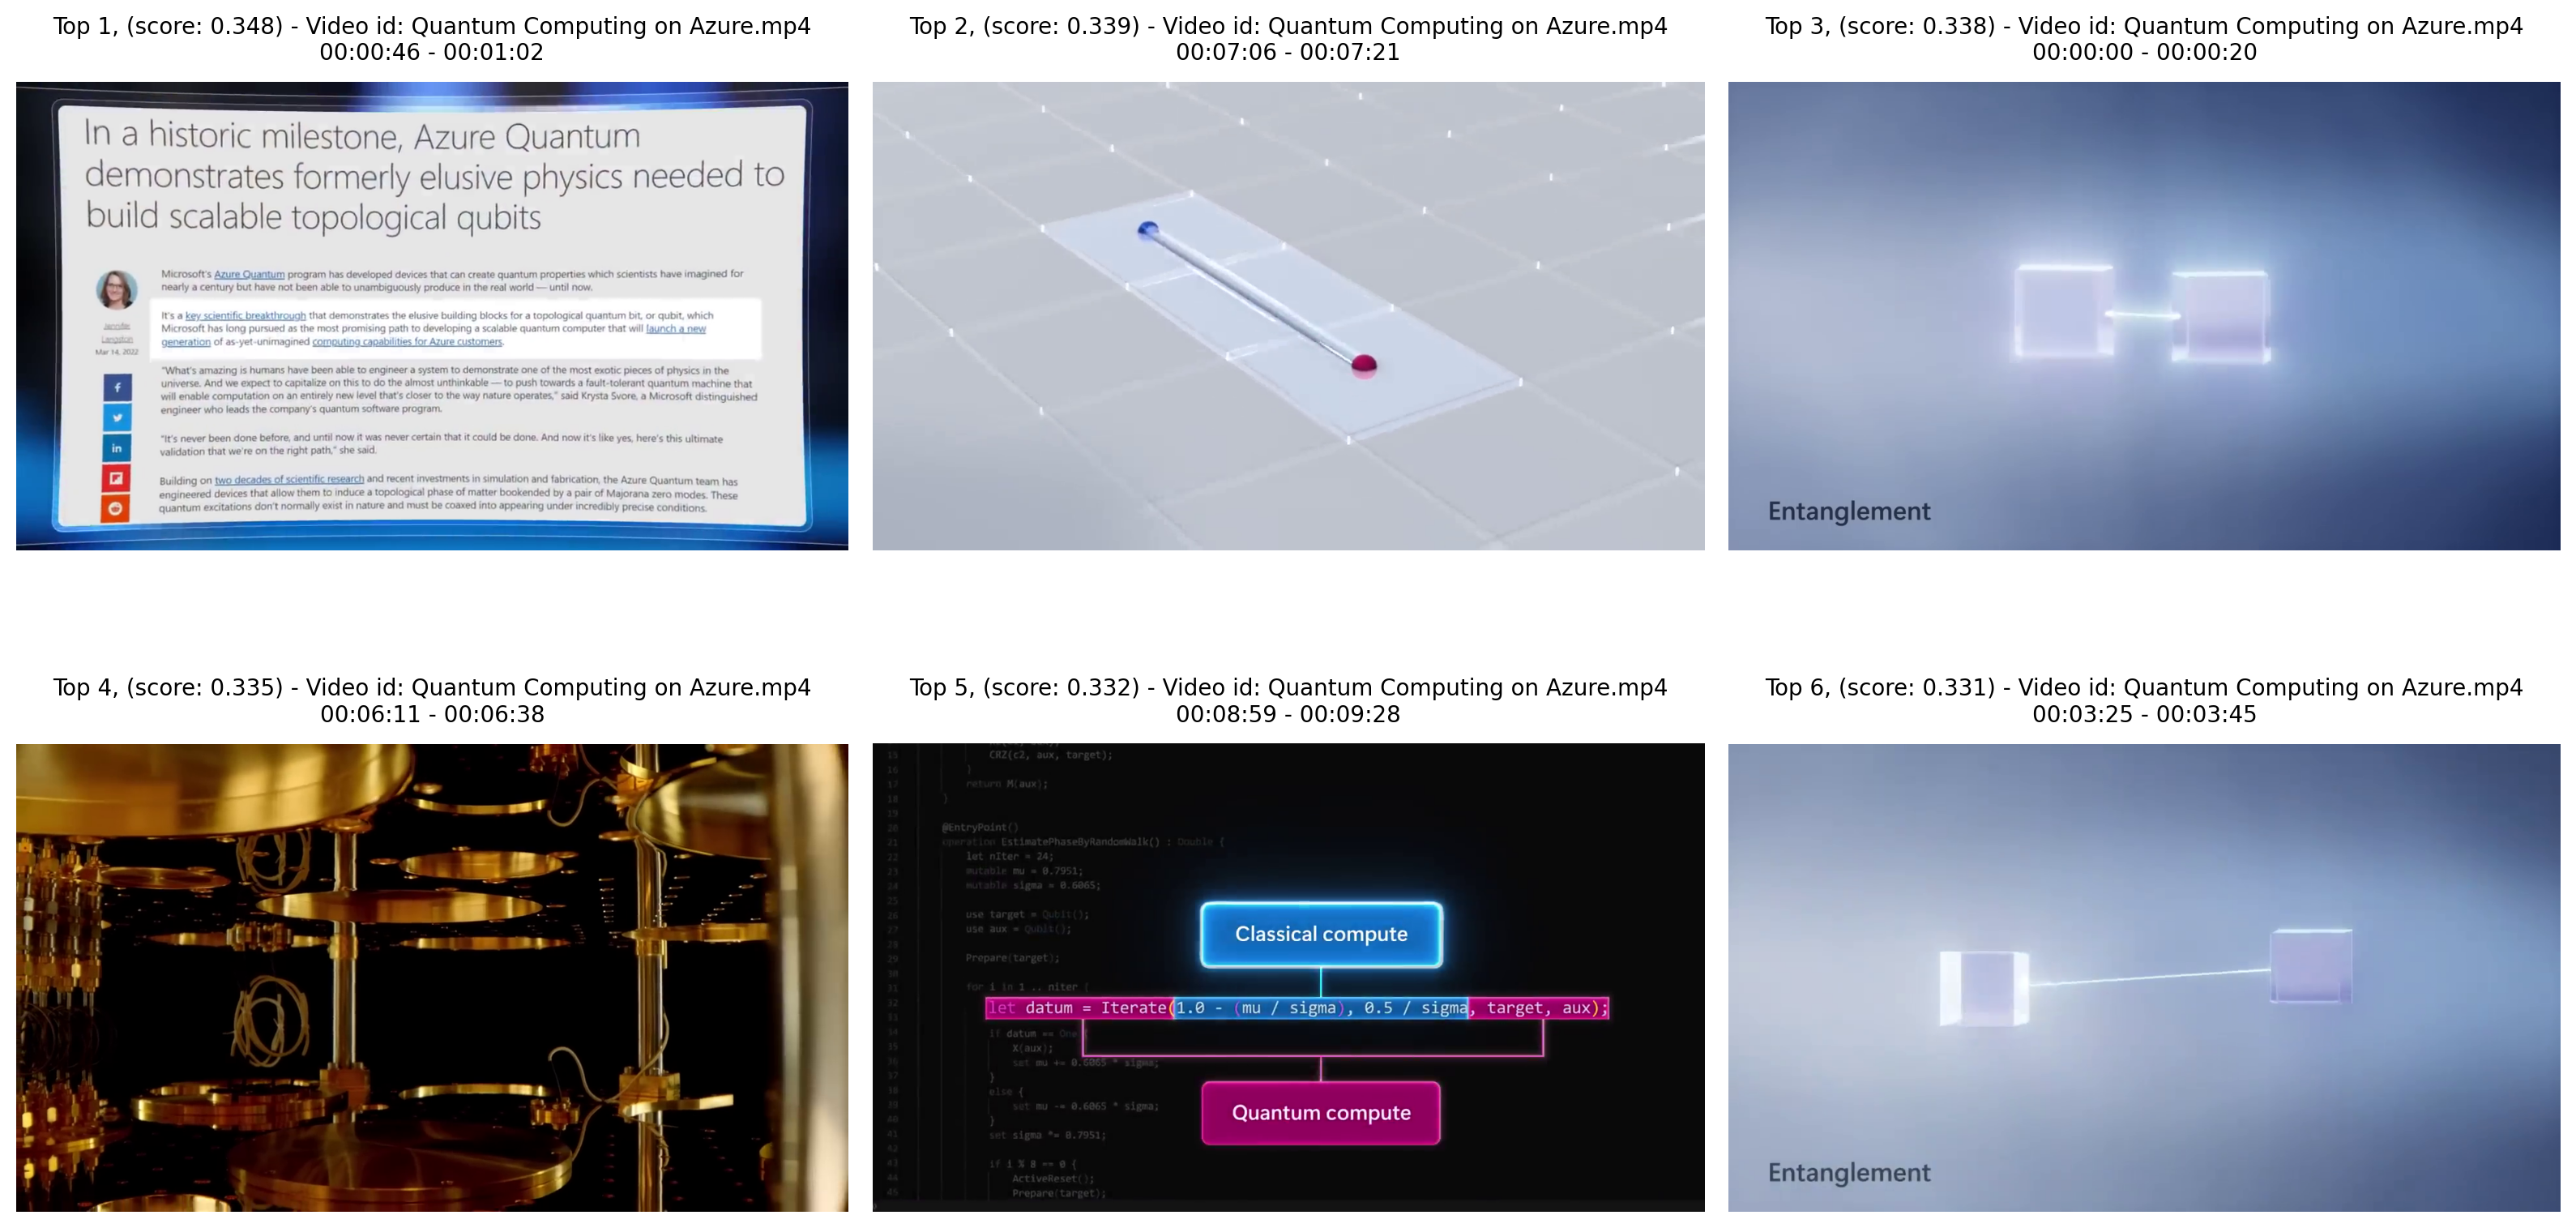

In [21]:
# search in audio and video tracks
query = "building a topological qubit"
search_results=find_scene(queryText=query, featureFilters=["speech", "vision"])['value']
top_matches_df=pd.DataFrame.from_records(search_results).head(6)

display_tiles(top_matches_df)

## Chat based video analysis

In [22]:
top_match_id = top_matches_df.iloc[0]['documentId']

video_url = indexed_videos_df[indexed_videos_df["documentId"]==top_match_id]['documentUrl'].values[0] 
video_url_sas = video_url + "?" + SAS_TOKEN
display(Video(video_url_sas, embed=False, width=800, html_attributes="controls muted autoplay"))

questions = ["Provide a summary of the video.",
             "Show a markdown table with timestamps and detailed descriptions of the scenes."]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(video_url=video_url, document_id=top_match_id, user_prompt=question)
    display(Markdown(response))

**Provide a summary of the video.**

The video features a discussion on the latest advances in quantum computing, focusing on Microsoft's topological approach to creating a scalable quantum machine. The guest, Microsoft distinguished Engineer Krista, highlights the significant breakthrough in March where they demonstrated the underlying physics for scalable quantum computing, aiming to integrate Microsoft's Quantum machine into Azure Quantum, their cloud platform for quantum innovation.

The video explains core concepts of quantum computing, comparing it to classical computing, and emphasizes the importance of qubits, superposition, entanglement, and interference in quantum mechanics. It also discusses the potential applications of quantum computing in solving complex problems that classical computers cannot, such as nitrogen fixation and carbon fixation to address environmental issues.

The video demonstrates setting up a high-performance quantum compute environment in Azure Quantum, running code on simulators and real quantum hardware, and the ease of switching between different quantum providers using the Quantum Intermediate Representation (QIR). It encourages viewers to start experimenting with quantum programming using Azure Quantum's diverse hardware, simulators, and learning materials.

The video concludes with an invitation to try Azure Quantum for free and to learn more about quantum programming through Microsoft's resources.

**Show a markdown table with timestamps and detailed descriptions of the scenes.**

| Timestamp | Scene Description |
|-----------|-------------------|
| 00:00:00 | A blank blue screen, likely the beginning of the video. |
| 00:00:27 | A computer screen displaying a code execution in a Jupyter notebook environment with a result table showing 'Result', 'Frequency', and 'Histogram' columns. |
| 00:01:02 | The Microsoft Azure portal interface is open on a computer screen, specifically on the Azure Quantum service page. |
| 00:01:58 | A blurred transition effect, possibly switching between scenes or topics in the video. |
| 00:02:38 | A person is seated at a desk with a laptop, engaged in conversation or presenting. |
| 00:03:14 | An illustration of a light bulb and a switch with the number '1' indicating a binary state, likely explaining the concept of classical bits. |
| 00:03:54 | The Microsoft Mechanics logo is displayed, indicating either the start of a new segment or branding. |
| 00:04:40 | The same person as earlier is seen again at the desk with a laptop, in a discussion or presentation setting. |
| 00:05:34 | A close-up of a chemical structure, possibly related to a discussion on quantum computing applications in chemistry. |
| 00:06:16 | A view of the Microsoft Quantum Labs, showing a piece of quantum computing hardware or experimental setup. |
| 00:06:43 | The same individual is back at the desk, continuing the conversation or presentation. |
| 00:07:24 | An animated graphic of a quantum computing concept, showing interconnected lines and nodes, possibly representing qubits and entanglement. |
| 00:08:12 | The individual at the desk appears again, likely elaborating on the previously shown concepts or graphics. |
| 00:08:46 | A rack of computer servers, possibly representing the classical computing infrastructure supporting quantum computing. |
| 00:09:35 | The person at the desk is visible once more, possibly concluding the discussion or moving on to another topic. |
| 00:10:40 | A confirmation screen on the Microsoft Azure portal indicating that a deployment is complete. |
| 00:12:01 | A Jupyter notebook with code, showing a function definition and a command ready to be executed. |
| 00:12:45 | A histogram result from a Jupyter notebook execution, displaying different probabilities for outcomes of a quantum computation. |
| 00:13:35 | A Jupyter notebook interface with a list of quantum providers and the ability to select one for executing quantum jobs. |
| 00:14:04 | The same person at the desk, likely wrapping up the presentation or providing closing remarks. |

## Systematic analysis of multiple videos

In [40]:
# show indexed videos
response = get_indexed_video_documents(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)

indexed_videos_df=pd.DataFrame.from_records(response.json()["value"])
metadata_fields=pd.json_normalize(indexed_videos_df["metadata"])
indexed_videos_df=pd.concat([indexed_videos_df,metadata_fields], axis=1)
del indexed_videos_df["metadata"]

analysis_df = indexed_videos_df[["documentId","filename","documentUrl"]].copy()
display(analysis_df.head())

documentId                        filename  \
0  Copilots and Plugins.mp4        Copilots and Plugins.mp4         
1  Create Avatar Videos.mp4        Create Avatar Videos.mp4         
2  Factory scene.mp4               Factory scene.mp4                
3  How LLMs improve Vision AI.mp4  How LLMs improve Vision AI.mp4   
4  Jugalbandi Chat Bot.mp4         Jugalbandi Chat Bot.mp4          

                                                                                  documentUrl  
0  https://saaksc.blob.core.windows.net/videos/samples/Copilots%20and%20Plugins.mp4            
1  https://saaksc.blob.core.windows.net/videos/samples/Create%20Avatar%20Videos.mp4            
2  https://saaksc.blob.core.windows.net/videos/samples/Factory%20scene.mp4                     
3  https://saaksc.blob.core.windows.net/videos/samples/How%20LLMs%20improve%20Vision%20AI.mp4  
4  https://saaksc.blob.core.windows.net/videos/samples/Jugalbandi%20Chat%20Bot.mp4

In [ ]:
questions = {
    "1_main_product": "What is the name of the main product or technology discussed in this video?",
    "2_product_use_cases": "What are the key use cases of the discussed product or technology? Provide them as a short list.",
    "3_technology_details": "Describe the technology specifics of the product or topic in detail.",
    "4_product_demonstration": "Is product or technology in this video demonstrated? How long is the demonstration?",
    "5_product_demo_style": "What is the product demonstration style? Choose one of the following style options: Entertaining, Instructive, Testing etc.",
    "6_call_to_action": "Is there a call-to-action about the product?"
}

# Iterating and printing each question
for column, question in questions.items():
    print(f"Processing question: {question}")
    analysis_df[column] = analysis_df.apply(lambda row: video_chat(video_url=row['documentUrl'], document_id=row['documentId'], user_prompt=question), axis=1)


In [27]:
# analysis_df.to_csv("analysis.csv", index=False)
analysis_df=pd.read_csv("analysis.csv")

styled_df = analysis_df.style.set_properties(**{'text-align': 'left', 'vertical-align': 'top'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

display(styled_df)
